Make J-plot from GOES/SUVI images to track the speed of a solar feature

In [1]:
# import matplotlib
# matplotlib.use('TkAgg') # nbAgg, Qt5Agg

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import UnivariateSpline
import astropy.io.fits as fits
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunkit_instruments import suvi
from scipy import stats
import sunpy.sun.constants as const
from copy import deepcopy
from scipy.ndimage import gaussian_filter
from PIL import Image
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, LogStretch, LogStretch, PercentileInterval

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

data_dir = '/home/mnedal/data'
savedir = '/home/mnedal/repos/dias_work'

In [2]:
os.makedirs(f'{savedir}/jplots/suvi/clicking', exist_ok=True)

In [3]:
def split_datetime(start=None, end=None):
    
    START_DATE, START_TIME = start.split('T')
    END_DATE, END_TIME = end.split('T')

    START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
    END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

    START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
    END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

    datetime_dict = {
        'start_year': START_YEAR,
        'start_month': START_MONTH,
        'start_day': START_DAY,
        'start_hour': START_HOUR,
        'start_minute': START_MINUTE,
        'start_second': START_SECOND,
        
        'end_year': END_YEAR,
        'end_month': END_MONTH,
        'end_day': END_DAY,
        'end_hour': END_HOUR,
        'end_minute': END_MINUTE,
        'end_second': END_SECOND
    }
    return datetime_dict



def plot_line(angle_deg=None, length=None, map_obj=None):
    """
    Plot a straight line at an angle in degrees from the solar West.
    """
    angle_rad = np.deg2rad(angle_deg)

    # Define the length of the line (in arcseconds)
    line_length = length * u.arcsec

    # Define the center point of the line (e.g., the center of the map)
    center = map_obj.center

    # Calculate the start and end points of the line
    start_point = SkyCoord(center.Tx, center.Ty, frame=map_obj.coordinate_frame)

    end_point = SkyCoord(center.Tx + line_length * np.cos(angle_rad),
                        center.Ty + line_length * np.sin(angle_rad),
                        frame=map_obj.coordinate_frame)
    
    line = SkyCoord([start_point, end_point])
    return line



def load_suvi(start=None, end=None, channel=195):
    """
    * 9.4 nm (FeXVIII)
    * 13.1 nm (FeXXI)
    * 17.1 nm (FeIX/X)
    * 19.5 nm (FeXII)
    * 28.4 nm (FeXV)
    * 30.4 nm (HeII)
    """
    dt_dict = split_datetime(start=start, end=end)
    data_path = f"{data_dir}/SUVI/{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}/{channel}A"
    root_filename = f"dr_suvi-l2-ci{channel}_g18_s"
    data = sorted(glob.glob(f"{data_path}/{root_filename}{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.fits"))
    
    start_file_to_find = f"{data_path}/{root_filename}{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}0000Z_e{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}0400Z_v1-0-2.fits"
    end_file_to_find   = f"{data_path}/{root_filename}{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}2800Z_e{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}3200Z_v1-0-2.fits"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = suvi.files_to_map(file, despike_l1b=True)
        min_range = 0
        if channel == 94:
            max_range = 20
        elif channel == 171:
            max_range = 20
        elif channel == 131:
            max_range = 20
        elif channel == 195:
            max_range = 50
        elif channel == 284:
            max_range = 50
        elif channel == 304:
            max_range = 100
        
        m.plot_settings['norm'] = ImageNormalize(vmin=min_range, vmax=max_range, stretch=LogStretch())
        map_objects.append(m)
        print(f'SUVI image {i} is done')
    return map_objects



def generate_centered_list(center, difference, num_elements):
    """
    Generate a list of numbers centered around a given number with a specified difference
    between consecutive numbers.

    Parameters:
    center (int): The central number around which the list is generated.
    difference (int): The difference between consecutive numbers in the list.
    num_elements (int): The number of elements before and after the central number.

    Returns:
    list: A list of numbers centered around the specified central number.
    """
    return [center + difference * i for i in range(-num_elements, num_elements + 1)]



def remove_redundant_maps(maps):
    """
    Remove redundant SunPy maps, keeping only one map per unique timestamp.

    Parameters:
    maps (list): List of SunPy Map objects. Each map is expected to have a 'date-obs' 
                 key in its metadata that provides the observation timestamp.

    Returns:
    list: A list of unique SunPy Map objects, one per unique timestamp.
    
    Example:
    >>> unique_maps = remove_redundant_maps(list_of_sunpy_maps)
    """
    unique_maps = {}
    for m in maps:
        timestamp = m.latex_name
        if timestamp not in unique_maps:
            unique_maps[timestamp] = m
    return list(unique_maps.values())



def apply_runratio(maps):
    """
    Apply running-ratio image technique on EUV images.
    See: https://iopscience.iop.org/article/10.1088/0004-637X/750/2/134/pdf
        Inputs: list of EUV sunpy maps.
        Output: sequence of run-ratio sunpy maps.
    """
    runratio = [m / prev_m.quantity for m, prev_m in zip(maps[1:], maps[:-1])]
    m_seq_runratio = sunpy.map.Map(runratio, sequence=True)
    
    for m in m_seq_runratio:
        m.data[np.isnan(m.data)] = 1
        m.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=2)
        m.plot_settings['cmap'] = 'Greys_r'
    
    return m_seq_runratio



def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized



def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax



def round_obstime(time=None):
    """
    Round the observation time to put it in the image title.
    Input : str, time (HH:MM:SS.sss)
    Output: str, datetime (YYYY-mm-DD HH:MM:SS)
    """
    from datetime import datetime, timedelta

    original_time_str = time

    # Convert the original time string to a datetime object
    original_time = datetime.strptime(original_time_str, '%H:%M:%S.%f')

    # Round the time to the nearest second
    rounded_time = original_time + timedelta(seconds=round(original_time.microsecond / 1e6))

    # Format the rounded time as 'HH:MM:SS'
    rounded_time_str = rounded_time.strftime('%H:%M:%S')
    
    return rounded_time_str



def compute_standard_error(coords_dict):
    # Extract all trials
    trials = list(coords_dict.values())
    num_points = len(trials[0])  # Number of points in each trial

    # Initialize lists to store standard errors
    mean_values = []
    standard_errors = []

    # Loop over each point position
    for point_idx in range(num_points):
        # Extract x and y values for this point across all trials
        x_values = [trials[trial_idx][point_idx][0] for trial_idx in range(len(trials))]
        y_values = [trials[trial_idx][point_idx][1] for trial_idx in range(len(trials))]

        # Convert to numpy arrays
        x_values = np.array(x_values)
        y_values = np.array(y_values)

        # Compute mean and standard error for this point
        mean_x = np.mean(x_values)
        mean_y = np.mean(y_values)
        se_x = np.std(x_values, ddof=1) / np.sqrt(len(x_values))
        se_y = np.std(y_values, ddof=1) / np.sqrt(len(y_values))

        # Store results
        mean_values.append((mean_x, mean_y))
        standard_errors.append((se_x, se_y))

    return mean_values, standard_errors



def onclick(event):
    """
    This function is called when the mouse is clicked on the figure.
    It adds the x and y coordinates of the click to the coords list.
    """
    global current_trial, text_handle

    if event.button == 1:  # Left mouse button
        xx, yy = event.xdata, event.ydata  # Get the central x and y coordinates
        ax.plot(xx, yy, 'ro', markersize=7)
        plt.draw()

        # Store the coordinates in the current trial's list
        feature_coords_slit[f'trial_{current_trial}'].append((xx, yy))
        
        # Update the text on the plot
        if text_handle:
            text_handle.remove()  # Remove the previous text
        text_handle = ax.text(0.05, 0.95, f"Trial {current_trial + 1}: Captured ({xx:.2f}, {yy:.2f})", 
                              transform=ax.transAxes, fontsize=12, verticalalignment='top', color='pink')
        plt.draw()

    elif event.button == 3:  # Right mouse button
        # Move to the next trial
        current_trial += 1
        if current_trial >= num_repeats:
            fig.canvas.mpl_disconnect(cid)
            plt.close(fig)  # Close the figure window
        else:
            if text_handle:
                text_handle.remove()
            text_handle = ax.text(0.05, 0.95, f"Moving to trial {current_trial + 1}", 
                                  transform=ax.transAxes, fontsize=12, verticalalignment='top', color='cyan')
            plt.draw()

In [4]:
# suvi_171_map_objects = load_suvi(start='2024-05-14T17:00:00', end='2024-05-14T18:00:00', channel=171)
suvi_195_map_objects = load_suvi(start='2024-05-14T17:00:00', end='2024-05-14T18:00:00', channel=195)
# suvi_284_map_objects = load_suvi(start='2024-05-14T17:00:00', end='2024-05-14T18:00:00', channel=284)

SUVI image 0 is done
SUVI image 1 is done
SUVI image 2 is done
SUVI image 3 is done
SUVI image 4 is done
SUVI image 5 is done
SUVI image 6 is done
SUVI image 7 is done
SUVI image 8 is done
SUVI image 9 is done
SUVI image 10 is done
SUVI image 11 is done
SUVI image 12 is done
SUVI image 13 is done
SUVI image 14 is done
SUVI image 15 is done
SUVI image 16 is done
SUVI image 17 is done
SUVI image 18 is done
SUVI image 19 is done
SUVI image 20 is done
SUVI image 21 is done


In [5]:
# print(len(suvi_171_map_objects), len(suvi_195_map_objects), len(suvi_284_map_objects))

In [6]:
# index = 0

# fig = plt.figure(figsize=[15,5])

# ax = fig.add_subplot(131, projection=suvi_171_map_objects[index])
# suvi_171_map_objects[index].plot(axes=ax)
# ax.grid(False)

# ax = fig.add_subplot(132, projection=suvi_195_map_objects[index])
# suvi_195_map_objects[index].plot(axes=ax)
# ax.grid(False)

# ax = fig.add_subplot(133, projection=suvi_284_map_objects[index])
# suvi_284_map_objects[index].plot(axes=ax)
# ax.grid(False)

# fig.tight_layout()
# plt.show()

In [7]:
# # Plot the map
# m = suvi_284_map_objects[7]

# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(projection=m)
# m.plot(axes=ax)
# ax.grid(False)

# # Plot the slits
# # centered_list = generate_centered_list(161, 4, 3)
# centered_list = generate_centered_list(160, 2, 3)

# for angle in centered_list:
#     line = plot_line(angle_deg=angle, length=1400, map_obj=m)
#     ax.plot_coord(line, color='tab:red')
    
#     # Plot the number at the end of the line
#     # Convert SkyCoord to pixel coordinates for plotting text
#     line_lon, line_lat = line.Tx, line.Ty
#     end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
    
#     # Display the number at the end point
#     ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{angle}$^o$',
#             color='tab:red', fontsize=10, ha='center', va='center')

# plt.show()

In [8]:
# clean_maps_171A = remove_redundant_maps(suvi_171_map_objects)
clean_maps_195A = remove_redundant_maps(suvi_195_map_objects)
# clean_maps_284A = remove_redundant_maps(suvi_284_map_objects)

# print(len(clean_maps_171A), len(clean_maps_195A), len(clean_maps_284A))

In [9]:
# make run-diff maps
# m_seq_runratio_171A = apply_runratio(clean_maps_171A)
m_seq_runratio_195A = apply_runratio(clean_maps_195A)
# m_seq_runratio_284A = apply_runratio(clean_maps_284A)

# print(len(m_seq_runratio_171A), len(m_seq_runratio_195A), len(m_seq_runratio_284A))

In [10]:
# rgb_image = np.stack([m_seq_runratio_171A[6].data,
#                       m_seq_runratio_195A[6].data,
#                       m_seq_runratio_284A[6].data],
#                      axis=-1)

# # Enhance contrast for each channel
# rgb_image_enhanced = np.zeros_like(rgb_image)
# for i in range(3):  # Process each channel independently
#     vmin, vmax = calculate_percentiles(rgb_image[..., i])
#     rgb_image_enhanced[..., i] = enhance_contrast(rgb_image[..., i], vmin, vmax)

In [29]:
# m = m_seq_runratio_195A[6]

slits = True
centered_list = generate_centered_list(160, 2, 6)

In [30]:
# fig = plt.figure(figsize=[7,7])
# ax = fig.add_subplot(111, projection=m)
# ax.imshow(rgb_image_enhanced, vmin=0, vmax=1)

# date_str = str(m.date).split('T')[0]
# rounded_time_str = round_obstime(time=str(m.date).split('T')[1])
# ax.set_title(f'SUVI 171, 195, 284 $\AA$ {date_str} {rounded_time_str}')
# ax.set_xlabel('Helioprojective Longitude (arcsec)')
# ax.set_ylabel('Helioprojective Latitude (arcsec)')

# if slits:
#     for value in centered_list:
#         line = plot_line(angle_deg=value, length=1870, map_obj=m)
#         ax.plot_coord(line, color='black')
        
#         # Plot the number at the end of the line
#         # Convert SkyCoord to pixel coordinates for plotting text
#         line_lon, line_lat = line.Tx, line.Ty
#         end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
        
#         # Display the number at the end point
#         ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{value}$^o$',
#                 color='black', fontsize=10, ha='center', va='center')
# plt.show()

In [31]:
# # Convert the 3D array to a 2D array by averaging the channels
# array_2d = np.mean(rgb_image_enhanced, axis=2)
# m = sunpy.map.Map(array_2d, m.meta)

In [32]:
# slits = True

# fig = plt.figure(figsize=[7,7])
# ax = fig.add_subplot(111, projection=m)
# m.plot(axes=ax, cmap='Greys_r', vmin=0.2, vmax=2)
# ax.set_title(f'SUVI 171, 195, 284 $\AA$ {date_str} {rounded_time_str}')

# if slits:
#     for value in centered_list:
#         line = plot_line(angle_deg=value, length=1870, map_obj=m)
#         ax.plot_coord(line, color='black')
        
#         # Plot the number at the end of the line
#         # Convert SkyCoord to pixel coordinates for plotting text
#         line_lon, line_lat = line.Tx, line.Ty
#         end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
        
#         # Display the number at the end point
#         ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{value}$^o$',
#                 color='black', fontsize=10, ha='center', va='center')
# plt.show()

### Inspect individual channel

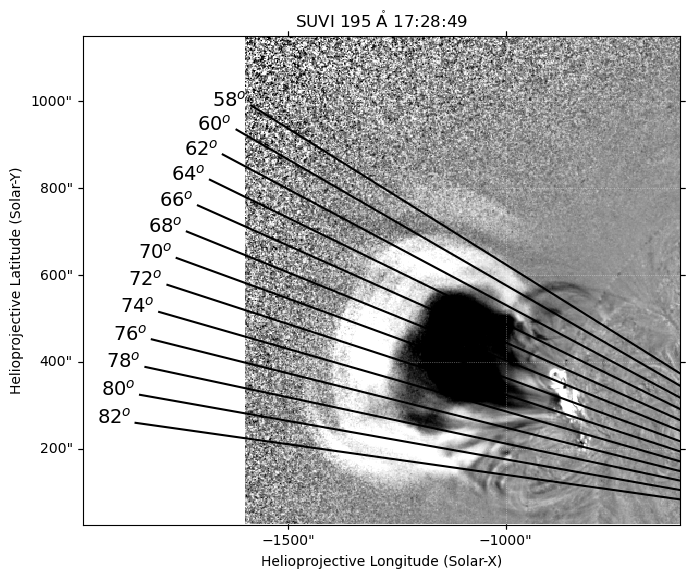

In [48]:
slits = True
position_angles = []
m = m_seq_runratio_195A[6]
m.plot_settings['norm'] = colors.Normalize(vmin=0.7, vmax=1.3)

# # crop the map
# top_right = SkyCoord(-200*u.arcsec, 1100*u.arcsec, frame=m.coordinate_frame)
# bottom_left = SkyCoord(-2200*u.arcsec, 50*u.arcsec, frame=m.coordinate_frame)
# m_submap = m.submap(bottom_left, top_right=top_right)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax, cmap='Greys_r')
ax.set_title(m.latex_name.replace('2024-05-14 ', ''))

if slits:
    for value in centered_list:
        line = plot_line(angle_deg=value, length=1870, map_obj=m)
        ax.plot_coord(line, color='black')
        
        # Plot the number at the end of the line
        # Convert SkyCoord to pixel coordinates for plotting text
        line_lon, line_lat = line.Tx, line.Ty
        end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1],
                                                           frame=m.coordinate_frame))
        
        # rename the angles to be position angles, instead of geometric angles
        PA_value = value - 90
        position_angles.append(PA_value)
        
        # Display the number at the end point
        ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 5, f'{PA_value}$^o$',
                color='black', fontsize=14, ha='center', va='center')

ax.set_xlim(left=-150, right=400)
ax.set_ylim(bottom=650, top=1100)
fig.tight_layout()
fig.savefig(f"{data_dir}/SUVI_{m.meta['wavelnth']}A_{m.meta['date-obs']}.pdf", format='pdf', bbox_inches='tight')
plt.show()

## J-Maps for SUVI

In [ ]:
suvi_rgb = []

for idx, _ in enumerate(m_seq_runratio_171A):
    
    rgb_image = np.stack([m_seq_runratio_171A[idx].data,
                          m_seq_runratio_195A[idx].data,
                          m_seq_runratio_284A[idx].data],
                         axis=-1)
    
    # Enhance contrast for each channel
    rgb_image_enhanced = np.zeros_like(rgb_image)
    for i in range(3):  # Process each channel independently
        vmin, vmax = calculate_percentiles(rgb_image[..., i])
        rgb_image_enhanced[..., i] = enhance_contrast(rgb_image[..., i], vmin, vmax)
    
    # Convert the 3D array to a 2D array by averaging the channels
    array_2d = np.mean(rgb_image_enhanced, axis=2)
    m = sunpy.map.Map(array_2d, m_seq_runratio_171A[idx].meta)
    suvi_rgb.append(m)

print('All SUVI RR images have been prepared as RGB-like sunpy maps', len(suvi_rgb))

In [ ]:
# Make a dictionary to hold the lists of lists
intensity_dict = {}
distances_dict = {}
output_obj = {}
jmaps_coords_list = {}

# Initialize each key with an empty list
for value in centered_list:
    intensity_dict[f'intensity_{value}deg'] = []
    distances_dict[f'distances_{value}deg'] = []
    output_obj[f'intensity_{value}deg'] = []
    output_obj[f'distances_{value}deg'] = []
    jmaps_coords_list[f'{value}'] = []

output_obj['time'] = []
output_obj['map_obj'] = []
output_obj['instrument'] = []

# for i, m in enumerate(suvi_rgb):
for i, m in enumerate(m_seq_runratio_195A):
    print(f'Working on map {i} ..')
    
    m.plot_settings['norm'] = colors.Normalize(vmin=0.7, vmax=1.3)
    
    fig = plt.figure(figsize=[7,7])
    ax = fig.add_subplot(111, projection=m)
    m.plot(axes=ax, cmap='Greys_r')#, vmin=0.2, vmax=2)
    
    for value in centered_list:
        line = plot_line(angle_deg=value, length=1870, map_obj=m)
        ax.plot_coord(line, color='black')
        
        # Plot the number at the end of the line
        # Convert SkyCoord to pixel coordinates for plotting text
        line_lon, line_lat = line.Tx, line.Ty
        end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
        
        # Display the number at the end point
        ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{value}$^o$',
                color='black', fontsize=10, ha='center', va='center')
        
        # obtain the coordinates of the map pixels that intersect that path
        intensity_coords_slit = sunpy.map.pixelate_coord_path(m, line)
        
        # Create mask to identify valid coordinates
        valid_mask = sunpy.map.contains_coordinate(m, intensity_coords_slit)
        
        # Apply the mask to filter valid coordinates
        valid_coords = intensity_coords_slit[valid_mask]
        
        # Pass those coordinates to extract the values for those map pixels
        intensity_slit = sunpy.map.sample_at_coords(m, valid_coords)
        
        # Calculate the angular separation between the first point and every other coordinate we extracted
        angular_separation_slit = valid_coords.separation(valid_coords[0]).to(u.arcsec)
        
        # Append the values to the lists
        intensity_dict[f'intensity_{value}deg'].append(list(intensity_slit.value))
        distances_dict[f'distances_{value}deg'].append(list(angular_separation_slit.value))
    
    output_obj['time'].append(m.date.iso)
    output_obj['map_obj'].append(m)
    output_obj['instrument'].append(f"SUVI {m.meta['wavelnth']}A")
#     output_obj['instrument'].append('SUVI_171_195_284_A')
    
    plt.show()

In [ ]:
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

for value in centered_list:
    intens = np.array(intensity_dict[f'intensity_{value}deg']).T
    height = np.array(distances_dict[f'distances_{value}deg'][0])
    output_obj[f'intensity_{value}deg'].append(intens)
    output_obj[f'distances_{value}deg'].append(height)

In [ ]:
list(intensity_dict.keys())

In [ ]:
list(distances_dict.keys())

In [ ]:
list(output_obj.keys())

In [ ]:
centered_list

In [ ]:
# [ 154, 156, 158, 160, 162, 164, 166 ]

In [ ]:
# ['/home/mnedal/repos/dias_work/jplots/lasco_C2/clicking/jmap_LASCO_C2_20240514_slit_148.csv',
#  '/home/mnedal/repos/dias_work/jplots/lasco_C2/clicking/jmap_LASCO_C2_20240514_slit_150.csv',
#  '/home/mnedal/repos/dias_work/jplots/lasco_C2/clicking/jmap_LASCO_C2_20240514_slit_152.csv',
#  '/home/mnedal/repos/dias_work/jplots/lasco_C2/clicking/jmap_LASCO_C2_20240514_slit_168.csv',
#  '/home/mnedal/repos/dias_work/jplots/lasco_C2/clicking/jmap_LASCO_C2_20240514_slit_170.csv',
#  '/home/mnedal/repos/dias_work/jplots/lasco_C2/clicking/jmap_LASCO_C2_20240514_slit_172.csv']

### Doing all the slits one by one because the for-loop didn't work ...

In [ ]:
angle = 172

height = output_obj[f'distances_{angle}deg'][0].copy()
intens = output_obj[f'intensity_{angle}deg'][0].copy()

print(f'Working on slit: {angle} deg.')

# Number of repetitions
num_repeats = 5
current_trial = 0

# Dictionary to store coordinates for each trial
feature_coords_slit = {f'trial_{i}': [] for i in range(num_repeats)}

# Text handle to update on the plot
text_handle = None

# plot the j-map
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
plt.ion()
ax.pcolormesh(datenum_arr, height, intens,
              vmin=0.5, vmax=1.7,
              cmap='Greys_r')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument'][0]} Intensity Along Slit {angle} deg")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_xlim(left=pd.Timestamp(f"{output_obj['time'][0].split(' ')[0]} 17:10:00"),
            right=pd.Timestamp(f"{output_obj['time'][0].split(' ')[0]} 17:55:00"))
ax.set_ylim(bottom=m.rsun_obs.value)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show(block=False)
plt.pause(0.001)

In [ ]:
# calc the standard error
mean_values, standard_errors = compute_standard_error(feature_coords_slit)

x_mean, y_mean = zip(*mean_values)
x_err, y_err = zip(*standard_errors)

event_date = output_obj['time'][0].split(' ')[0].replace('-','')
output_filename = f"jmap_{output_obj['instrument'][0]}_{event_date}_slit_{angle}"

df = pd.DataFrame({'time': x_mean, 'distance': y_mean,
                   'x_err': x_err, 'y_err': y_err})
df.to_pickle(f'{savedir}/jplots/suvi/clicking/coords_{output_filename}.pkl')

# Extract time and distance arrays from the selected coordinates
times_num, distances = df['time'].values, df['distance'].values

# Perform linear regression to fit a line
slope, intercept, r_value, p_value, std_err = stats.linregress(times_num, distances)

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)

# conversion factor from arcsec to km
conversion_factor = sol_rad/output_obj['map_obj'][0].rsun_obs

# store the curve points with error bars
df['x_mean'] = x_mean
df['y_mean'] = y_mean
df['x_err'] = x_err
df['y_err'] = y_err

# convert distance from arcsec to km
df['distance_km'] = distances * conversion_factor.value

# calculate the distance difference in km
df['distance_diff_km'] = df['distance_km'].diff()

# convert time to datetime format
df['datetime'] = [mdates.num2date(t) for t in times_num]

# calculate the time difference in seconds
df['time_diff_s'] = df['datetime'].diff().dt.total_seconds()

# calculate the speed in km/s
df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']

df.to_csv(f'{savedir}/jplots/suvi/clicking/{output_filename}.csv')
print(f'J-plot data saved at: {savedir}/jplots/suvi/clicking/{output_filename}.csv')

# # drop the first row which will have NaN values for the differences
# df.dropna(inplace=True)

# Calculate spline fit
spline = UnivariateSpline(times_num, distances, k=1, s=None) # s=0 for interpolation through all points

# Generate the spline line
spline_times = np.linspace(min(times_num), max(times_num), 1000)
spline_distances = spline(spline_times)

# Calculate the derivative of spline_distances with respect to spline_times
spline_velocity = spline.derivative()(spline_times)

# Convert velocity (in arcsec/day) to speed in km/s
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_spline = spline_velocity * conversion_factor.value / 86400  # km/s

# Calculate the polynomial fit
polyfit_coeff = np.polyfit(times_num, distances, 2)  # Fit a 2nd order polynomial
polyfit_line = np.polyval(polyfit_coeff, spline_times)

# Calculate the derivative of the polynomial fit (velocity)
polyfit_velocity = np.polyval(np.polyder(polyfit_coeff), spline_times)
speed_polyfit = polyfit_velocity * conversion_factor.value / 86400  # km/s

# show the final J-map with the fitting lines and speed estimations
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.pcolormesh(datenum_arr, height, intens, vmin=0.5, vmax=1.7, cmap='Greys_r')

# Plot the fitted line
fit_line = slope*times_num + intercept

# Calculate the speed (slope in arcsec/day to speed in km/s)
speed_fit = slope * conversion_factor.value/86400  # km/s
speed = df['speed_km_s'].mean()

# Plot the selected points with error bars
ax.errorbar(x_mean, y_mean, xerr=x_err, yerr=y_err,
            fmt='ro', ecolor='blue', barsabove=False,
            markersize=4, elinewidth=1, capsize=3, label=f'Mean speed: {speed:.2f} km/s')

ax.plot(times_num, fit_line, ls='--', color='yellow',
        label=f'Linear fit: {speed_fit:.2f} km/s')

# Plot the spline fit line
ax.plot(spline_times, spline_distances, ls='--', color='tab:red',
        label=f'Spline fit: {np.nanmean(speed_spline):.2f} km/s')

# Plot the polynomial fit line
ax.plot(spline_times, polyfit_line, ls='-', color='tab:blue',
           label=f'2nd-order Polynomial fit: {np.nanmean(speed_polyfit):.2f} km/s')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument'][0]} Intensity Along Slit {angle} deg.")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend(loc='lower right')
ax.set_xlim(left=pd.Timestamp(f"{output_obj['time'][0].split(' ')[0]} 17:10:00"),
            right=pd.Timestamp(f"{output_obj['time'][0].split(' ')[0]} 17:55:00"))
ax.set_ylim(bottom=m.rsun_obs.value)
fig.tight_layout()
fig.savefig(f'{savedir}/jplots/suvi/clicking/{output_filename}.png',
            format='png', bbox_inches='tight')
print(f'Figure: {output_filename} has been exported.\n')
plt.show()